In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import fetch_lfw_pairs
import os
import re
import tensorflow as tf

In [3]:
from PIL import Image
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

### About the dataset : AT&T face dataset
https://www.kaggle.com/kasikrit/att-database-of-faces <br>
Color: Grey-scale <br>
Sample Size: 92x112 <br>
Individuals: 40 <br>
Samples: 400 <br>

The size of each image is 92x112 pixels, with 256 grey levels per pixel. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10).

For the dataset used here we already have image of the face only, if that is not the case face detection should be done first. FaceNet or OpenCV haarcascade can be used for this purpose.

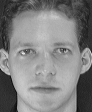

In [6]:
Image.open("data/orl_faces/s1/1.pgm")

read_image function takes as input an image and returns a numpy array

In [5]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"     #header
        b"(\d+)\s(?:\s*#.*[\r\n])*"    #width
        b"(\d+)\s(?:\s*#.*[\r\n])*"    #height
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()    #maxval
    
    #then we convert the image to numpy array using np.frombuffer which 
    #interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

In [9]:
img = read_image('data/orl_faces/s1/1.pgm')

In [10]:
img.shape

(112, 92)

Siamese networks require input values as a pair along with the label, so we have to create our data in such a way. So, we will take two images randomly from the same folder and mark them as a genuine pair (true pair) and we will take single images from two different folders and mark them as an imposite pair (false pair). 

In [11]:
size = 2
total_sample_size = 10000

def get_data(size, total_sample_size):
    #read the image
    image = read_image('data/orl_faces/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])  # 2 is for pairs
    y_true = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (true pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('data/orl_faces/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('data/orl_faces/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (true pair)
            y_true[count] = 1
            count += 1

    count = 0
    x_false_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_false = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (false pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('data/orl_faces/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('data/orl_faces/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_false_pair[count, 0, 0, :, :] = img1
            x_false_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (false pair)
            y_false[count] = 0
            count += 1
            
    #now, concatenate, true pairs and false pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_false_pair], axis=0)/255
    Y = np.concatenate([y_true, y_false], axis=0)

    return X, Y

In [12]:
X, Y = get_data(size, total_sample_size)

20,000 data points and out of these, 10,000 are genuine pairs and 10,000 are imposite pairs

In [13]:
X.shape

(20000, 2, 1, 56, 46)

In [14]:
Y.shape

(20000, 1)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

we build our siamese network. First, we define the base network, which is basically a convolutional network used for feature extraction. We build two convolutional layers with ReLU activations and max pooling followed by a flat layer

In [16]:
input_dim = x_train.shape[2:]
##############################################################################
seq = Sequential()

nb_filter = [6, 12]
kernel_size = 3

#convolutional layer 1
seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                      border_mode='valid', dim_ordering='th'))
seq.add(Activation('relu'))
seq.add(MaxPooling2D(pool_size=(2, 2)))  
seq.add(Dropout(.25))

#convolutional layer 2
seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
seq.add(Activation('relu'))
seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
seq.add(Dropout(.25))

#flatten 
seq.add(Flatten())
seq.add(Dense(128, activation='relu'))
seq.add(Dropout(0.1))
seq.add(Dense(50, activation='relu'))
########################################################################################################

base_network = seq

Next, we feed the image pair to the base network, which will return the embeddings, that is, feature vectors

In [18]:
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

C:\Users\KHANNAS\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (3, 3), input_shape=(1, 56, 46..., padding="valid", data_format="channels_first")`
  # This is added back by InteractiveShellApp.init_path()


C:\Users\KHANNAS\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (3, 3), padding="valid", data_format="channels_first")`
C:\Users\KHANNAS\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`


feat_vecs_a and feat_vecs_b are the feature vectors of our image pair. Next, we feed these feature vectors to the energy function to compute the distance between them, and we use Euclidean distance as our energy function:

In [19]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [20]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [23]:
def triplet_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [24]:
epochs = 13
rms = RMSprop()
model = Model(input=[img_a, img_b], output=distance)
model.compile(loss=triplet_loss, optimizer=rms)

Time to train our model

In [26]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]

model.fit([img_1, img2], y_train, validation_split=.25,
          batch_size=128, verbose=2, nb_epoch=epochs)

C:\Users\KHANNAS\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 11250 samples, validate on 3750 samples
Epoch 1/13
 - 38s - loss: 0.1839 - val_loss: 0.2306
Epoch 2/13
 - 27s - loss: 0.1142 - val_loss: 0.1676
Epoch 3/13
 - 27s - loss: 0.0832 - val_loss: 0.1110
Epoch 4/13
 - 28s - loss: 0.0658 - val_loss: 0.0599
Epoch 5/13
 - 28s - loss: 0.0541 - val_loss: 0.0502
Epoch 6/13
 - 26s - loss: 0.0472 - val_loss: 0.0432
Epoch 7/13
 - 26s - loss: 0.0418 - val_loss: 0.0418
Epoch 8/13
 - 28s - loss: 0.0377 - val_loss: 0.0286
Epoch 9/13
 - 29s - loss: 0.0350 - val_loss: 0.0256
Epoch 10/13
 - 30s - loss: 0.0325 - val_loss: 0.0298
Epoch 11/13
 - 29s - loss: 0.0306 - val_loss: 0.0219
Epoch 12/13
 - 29s - loss: 0.0278 - val_loss: 0.0189
Epoch 13/13
 - 29s - loss: 0.0267 - val_loss: 0.0193


In [27]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [28]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

In [29]:
compute_accuracy(pred, y_test)

0.964759378552482